In [387]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? t
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# RUN BLR

In [61]:
! rm -r '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'
! mkdir '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'

In [62]:
import os
os.chdir('/Users/ltran/Documents/TrueData29/CPC_ML_tutorial/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import random

from scipy.stats import fisher_exact
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d
from sklearn.model_selection import train_test_split
# Set data directory
data_dir = '/Users/ltran/Documents/Data/'

# Set working directory
root_dir = '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/'
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

## Load DF_ALL

In [64]:
# Load dataframe containing TCA + TSA + TD
df = pd.read_csv(os.path.join(data_dir, 'Outputs/df_tsa_tca.csv'))

In [65]:
df['site'] = df['scanner']

In [66]:
df_all.groupby('ASD').size()

ASD
No            188
Pas_ASD        17
Relative      214
TCA             4
TCA_ac         40
TCA_pr         49
TD_Patient      3
Yes           536
dtype: int64

### Define ROI

### Surface

In [41]:
all_cols = [col for col in df_all.columns if '_area' in col]

In [358]:
all_cols.remove( 'rh_WhiteSurfArea_area')
all_cols.remove( 'lh_WhiteSurfArea_area')
all_cols.remove('Left_Accumbens_area')
all_cols.remove('Right_Accumbens_area')

In [359]:
len(all_cols)

68

In [360]:
idp_ids = all_cols

### Volumes

In [67]:
idp_ids = ['Left_Accumbens_area', 'Left_Amygdala', 'Left_Caudate',
             'Left_Hippocampus','Left_Pallidum','Left_Putamen', 
             'Left_Thalamus', 'Left_Lateral_Ventricle',
             'Right_Accumbens_area', 'Right_Amygdala', 'Right_Caudate',
             'Right_Hippocampus','Right_Pallidum','Right_Putamen', 
             'Right_Thalamus', 'Right_Lateral_Ventricle']

In [229]:
cols_cov = ['age_at_scan','sex', 'global', 'fwd']

### Thickness

In [36]:
all_cols = [col for col in df_all.columns if '_thickness' in col]


In [37]:
all_cols.remove('rh_MeanThickness_thickness')
all_cols.remove('lh_MeanThickness_thickness')

In [38]:
len(all_cols)

68

In [39]:
idp_ids = all_cols

In [40]:
df_all['mean_ct'] = df_all[all_cols].mean(axis =1 )

## Split dataframe into TCA/TSA/TD

In [70]:
df_tca = df_all[(df_all.ASD == 'TCA' )
               | (df_all.ASD == 'TCA_ac')
               | (df_all.ASD == 'TCA_pr')]

In [71]:
df_td= df_all[(df_all.ASD == 'No')
              | (df_all.ASD == 'Relative')]
df_tsa =  df_all[df_all.ASD == 'Yes']

## Match on age

In [72]:
df_tsa = df_tsa[(df_tsa.age_at_scan < 16) & (df_tsa.age_at_scan > 6)]

In [73]:
df_tca = df_tca[(df_tca.age_at_scan < 16) & (df_tca.age_at_scan > 6)] 

# Run BLR

In [74]:
pred_bool = input("Prediction on TD + ASD : 1 \nPrediction on ASD only : 2\n")

Prediction on TD + ASD : 1 
Prediction on ASD only : 2
1


In [75]:
# Metric DataFrame
metric_analysis = pd.DataFrame(columns = ['ROIs', 'EV mean', 'EV max', 'MSLL mean', 'MSLL min', 'Covs', 'Fixed effect', 'xmin', 'xmax', 'Outlier Thresh'])



In [76]:
# Choosing covariates
cols_cov = ['age_at_scan','sex', 'mean_ct' ]

# EstimatedTotalIntraCranialVol 
# mean_ct


fixed_effect = 'NA'

# Type of Warping 
warp =  'WarpSinArcsinh'


# B-Spline limits
xmin = round(df_td['age_at_scan'].min() - 5) # ~ age min - 5 
xmax = round(df_td['age_at_scan'].max() + 5) # ~ age max + 5

force_refit = True 

# Threshold for outliers
outlier_thresh = 5

In [78]:
# DataFrame with only TD

# EstimatedTotalIntraCranialVol
# meanCT

strat = ['age_at_scan', 'sex', 'site', 'mean_ct']
if (pred_bool == '1'):
    
    

    #Split train & test, stratified by site
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                        test_size=0.33, 
#                                                         random_state=42,
                                                       stratify = df_td[[ 'sex','site']])

    df_trx, df_tex2, df_try, df_tey2 = train_test_split(df_sx, df_sy, 
                                                       test_size = 0.5, 
#                                                         random_state=42, 
                                                      stratify = df_sx[[ 'sex','site']])

    df_te1 = df_tex1.join(df_tey1).join(df_td[['ASD',  'participant_id', 'scanner']])
    df_te2 = df_tex2.join(df_tey2).join(df_td[['ASD', 'participant_id', 'scanner']])

    df_tr = df_trx.join(df_try).join(df_td[['ASD', 'participant_id', 'scanner']])
elif (pred_bool == '2'):
    
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                    test_size=0.5, 
                                                    random_state=42,
                                                   stratify = df_td[['sex', 'site']])
    df_tr = df_sx.join(df_sy).join(df_td[['ASD', 'mean_ct']])
    df_te1 = df_tex1.join(df_tey1).join(df_td[['ASD', 'mean_ct']])

In [79]:
site_ids = set(df_tr['site'])
site_ids_tr = set(df_tr['site'])
site_ids_te = set(df_te1['site'])


for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')

    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)

    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te1[idp].to_numpy()

    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    y_tr = y_tr[nz_tr]
    y_te = y_te[nz_te]

    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)

    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                site_ids = df_tr['site'].loc[nz_tr],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te1[cols_cov].loc[nz_te], 
                                site_ids = df_te1['site'].loc[nz_te], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'

        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)

    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  

        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp

        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]

        # evaluation metrics
        metrics = evaluate(y_te, med_te)

        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     

    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtfddfosis, semean, sesd] = calibration_descriptives(Z)

    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik

    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]

display(blr_metrics)

blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))
new_row = {'ROIs' : len(idp_ids) , 'EV mean': blr_metrics['EV'].mean(), 'EV max' : blr_metrics['EV'].max() , 'MSLL mean': blr_metrics['MSLL'].mean(), 'MSLL min' : blr_metrics['MSLL'].min(), 'Covs' : cols_cov, 'Fixed effect' : fixed_effect , 'xmin' : xmin, 'xmax' : xmax, 'Outlier Thresh' : outlier_thresh}
metric_analysis = metric_analysis.append(new_row, ignore_index=True)

Running IDP 0 Left_Accumbens_area :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Accumbens_area/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 Left_Amygdala :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Amygdala/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 2 Left_Caudate :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.86951e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.50276e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.05685e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.78715e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Caudate/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 3 Left_Hippocampus :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Hippocampus/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 4 Left_Pallidum :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.31966e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.5035e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09125e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.13044e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Pallidum/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 5 Left_Putamen :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Putamen/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 6 Left_Thalamus :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Thalamus/resp_tr.txt


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.61722e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.08367e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.42176e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.1184e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 7 Left_Lateral_Ventricle :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left_Lateral_Ventricle/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 8 Right_Accumbens_area :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Right_Accumbens_area/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.40639e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.27235e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24447e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.08143e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 9 Right_Amygdala :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Right_Amygdala/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 10 Right_Caudate :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Right_Caudate/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 11 Right_Hippocampus :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Right_Hippocampus/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving 

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39111e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.77835e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.46744e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.1233e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Right_Putamen/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 14 Right_Thalamus :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Right_Thalamus/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 15 Right_Lateral_Ventricle :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90233e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.30429e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.09534e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.22881e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Right_Lateral_Ventricle/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
0,Left_Accumbens_area,852.331494,0.028751,-7.287627,1724.254346,-0.429879,1.913800
1,Left_Amygdala,926.610594,0.065195,-4.405445,1872.812548,-0.286156,-0.033667
2,Left_Caudate,1050.092441,0.150161,-1.653084,2119.776241,-0.721469,4.107493
3,Left_Hippocampus,1025.758433,0.192093,-1.690644,2071.108225,-0.973059,3.252623
4,Left_Pallidum,940.821738,0.119485,-3.452400,1901.234836,-0.820362,3.965727
5,Left_Putamen,1060.153506,0.176856,-0.953630,2139.898371,-0.942651,3.579490
6,Left_Thalamus,1110.590395,0.249359,-0.956443,2240.772149,-0.343921,0.484719
7,Left_Lateral_Ventricle,1285.947001,0.166466,-0.080553,2591.485362,0.338208,0.192573
8,Right_Accumbens_area,847.649395,0.099585,-7.143454,1714.890150,-1.545357,9.545569
9,Right_Amygdala,944.208900,0.085553,-4.284602,1908.009160,-0.222205,-0.327202


/var/folders/p5/qymxnxk12156bhtw2jlf3sb40000gr/T/ipykernel_46631/3479435258.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_analysis = metric_analysis.append(new_row, ignore_index=True)


In [80]:
blr_metrics.EV.mean()

0.12601756679327641

In [81]:
blr_metrics[blr_metrics.EV == blr_metrics.EV.max()]

,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
6,Left_Thalamus,1110.590395,0.249359,-0.956443,2240.772149,-0.343921,0.484719


In [82]:
blr_metrics.describe()

,NLL,EV,MSLL,BIC,Skew,Kurtosis
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,1030.942775,0.126018,-2.546083,2081.476909,-0.576016,2.789295
std,125.509222,0.061772,2.261900,251.018445,0.637429,3.306872
min,847.649395,0.028751,-7.287627,1714.890150,-1.839606,-0.327202
25%,942.768918,0.080464,-3.660450,1905.129196,-0.889296,0.502786
50%,1037.925437,0.126675,-1.671864,2095.442233,-0.506081,1.571742
75%,1071.774709,0.169063,-0.999601,2163.140778,-0.329480,3.676049
max,1285.947001,0.249359,-0.070962,2591.485362,0.806884,11.090854


## Predict Z-Scores

In [ ]:
# Predict Z-Scores on AN (df_tca) or ASD (df_tsa)

df_temp = df_tca

# df_temp = df_tsa

In [83]:


if (pred_bool == '1'):
    df_te3 = pd.concat([df_temp, df_te2])
elif (pred_bool == '2'):
    df_te3 = df_temp

In [84]:
df_te3 = df_te3[(df_te3['age_at_scan'] > 6) & (df_te3['age_at_scan'] < 16)]

In [85]:
df_te3.groupby('ASD').size()

ASD
No          38
Relative    10
TCA          4
TCA_ac      40
TCA_pr      49
dtype: int64

In [86]:

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # extract and save the response variables for the test set
    y_te = df_te3[idp].to_numpy()

    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te3[cols_cov], 
                                site_ids = df_te3['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)

    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')

        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')

        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov], 
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')          
        np.savetxt(cov_file_ad, X_ad)

        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt') 
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)

        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt') 
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)

        # save the site ids for the test data 
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)

        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg = 'blr', 
                                    respfile = resp_file_te, 
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 Left_Accumbens_area :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 Left_Amygdala :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 Left_Caudate :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 Left_Hippocampus :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 Left_Pallidum :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 5 Lef

# Extract Z-scores

In [87]:

def fetch_raw_Z():
    # Read outputs files 
    Z_pred = {}

    for idp_num, idp in enumerate(idp_ids): 
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)
        f = open("Z_predict.txt", "r")
        Z_pred.update({f'{idp}_Z_predict' : f.readlines()})

    Z_df_pred = pd.DataFrame(Z_pred).astype(float)
    
    return Z_df_pred

In [88]:
Z_df = fetch_raw_Z()

In [89]:
Z_df = fetch_raw_Z()
Z_df = Z_df.join(df_te3.reset_index(drop = True))

## Export Z-Scores

In [91]:
# Don't fortget to give name to the output file 


Z_df.to_csv(os.path.join(data_dir, 'Outputs/Z_tca_vol.csv'))

## Export EV

In [195]:
blr_metrics.to_csv(os.path.join(data_dir, 'Outputs/blr_metrics.csv'), index = False)

# Plot trajectories

In [62]:
sex = 2

configuring dummy data ...
Running IDP 0 lh_bankssts_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16301528]), 'Rho': array([0.70896742]), 'pRho': array([1.01499423e-16]), 'SMSE': array([0.64548828]), 'EXPV': array([0.36937913])}


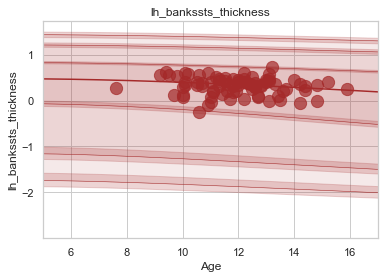

Running IDP 1 lh_caudalanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22280951]), 'Rho': array([0.16029912]), 'pRho': array([0.12931183]), 'SMSE': array([1.02682598]), 'EXPV': array([-0.00688122])}


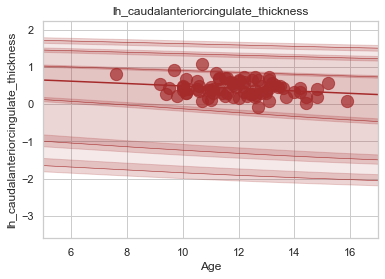

Running IDP 2 lh_caudalmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19514658]), 'Rho': array([0.51449559]), 'pRho': array([9.49940314e-08]), 'SMSE': array([1.12128755]), 'EXPV': array([0.24868605])}


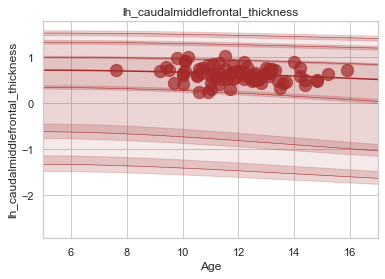

Running IDP 3 lh_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17605187]), 'Rho': array([0.63478955]), 'pRho': array([2.06571395e-12]), 'SMSE': array([0.95571016]), 'EXPV': array([0.30759353])}


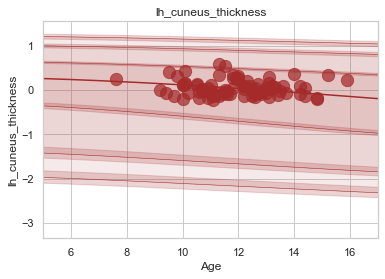

Running IDP 4 lh_entorhinal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.4659619]), 'Rho': array([-0.09843487]), 'pRho': array([0.35423772]), 'SMSE': array([2.1969612]), 'EXPV': array([-0.16656145])}


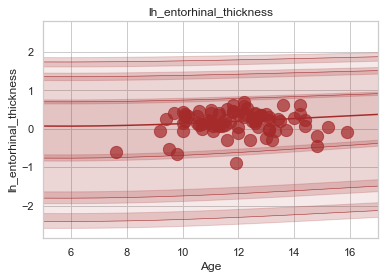

Running IDP 5 lh_fusiform_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14647292]), 'Rho': array([0.45565449]), 'pRho': array([3.95718759e-06]), 'SMSE': array([1.23423841]), 'EXPV': array([0.19069753])}


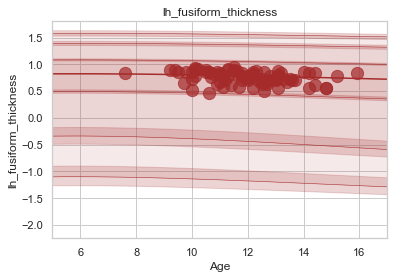

Running IDP 6 lh_inferiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20876035]), 'Rho': array([0.69633036]), 'pRho': array([7.0969976e-16]), 'SMSE': array([1.19345494]), 'EXPV': array([0.38111629])}


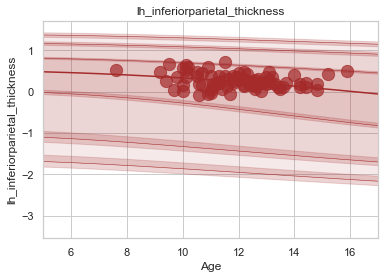

Running IDP 7 lh_inferiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15856094]), 'Rho': array([0.51021556]), 'pRho': array([1.28055941e-07]), 'SMSE': array([1.22572744]), 'EXPV': array([0.24613281])}


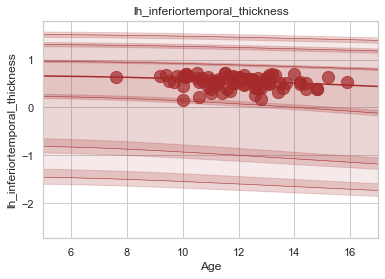

Running IDP 8 lh_isthmuscingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15684694]), 'Rho': array([0.49031495]), 'pRho': array([4.83921172e-07]), 'SMSE': array([0.80241601]), 'EXPV': array([0.22488494])}


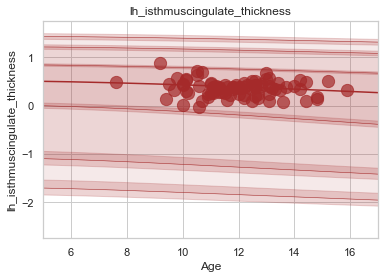

Running IDP 9 lh_lateraloccipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14988155]), 'Rho': array([0.76798641]), 'pRho': array([1.64567041e-21]), 'SMSE': array([0.82613397]), 'EXPV': array([0.41089912])}


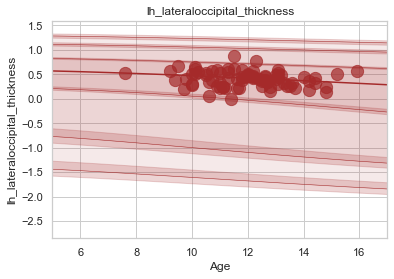

Running IDP 10 lh_lateralorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17589733]), 'Rho': array([0.6434362]), 'pRho': array([7.66016682e-13]), 'SMSE': array([0.80071751]), 'EXPV': array([0.37709654])}


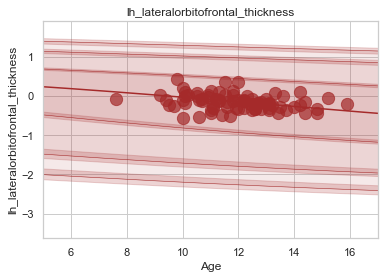

Running IDP 11 lh_lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11329743]), 'Rho': array([0.79580007]), 'pRho': array([2.03519907e-24]), 'SMSE': array([0.65608347]), 'EXPV': array([0.48076865])}


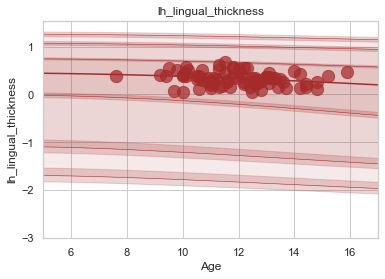

Running IDP 12 lh_medialorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12983146]), 'Rho': array([0.69894022]), 'pRho': array([4.7968192e-16]), 'SMSE': array([0.56750311]), 'EXPV': array([0.43340336])}


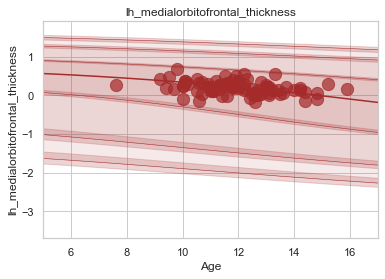

Running IDP 13 lh_middletemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13849179]), 'Rho': array([0.69266443]), 'pRho': array([1.22010085e-15]), 'SMSE': array([0.61327689]), 'EXPV': array([0.43099389])}


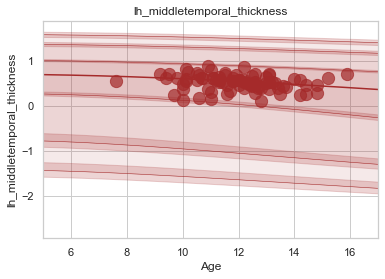

Running IDP 14 lh_parahippocampal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.29813816]), 'Rho': array([0.12522334]), 'pRho': array([0.23764341]), 'SMSE': array([1.1350459]), 'EXPV': array([-0.00657329])}


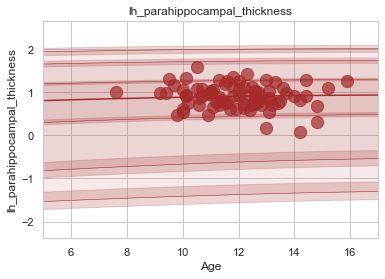

Running IDP 15 lh_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2101846]), 'Rho': array([0.62619494]), 'pRho': array([5.34314489e-12]), 'SMSE': array([1.11625717]), 'EXPV': array([0.32332041])}


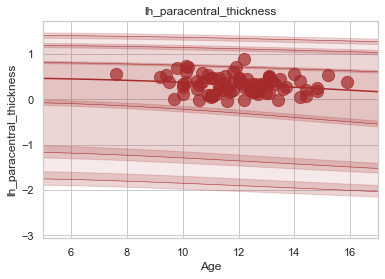

Running IDP 16 lh_parsopercularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1236601]), 'Rho': array([0.73745153]), 'pRho': array([7.74286827e-19]), 'SMSE': array([0.58220032]), 'EXPV': array([0.45424377])}


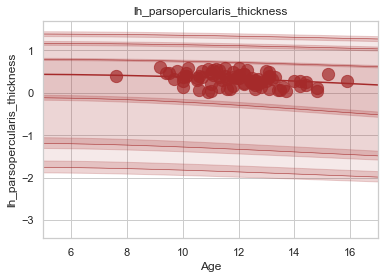

Running IDP 17 lh_parsorbitalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17580238]), 'Rho': array([0.67967837]), 'pRho': array([7.71533376e-15]), 'SMSE': array([0.56640461]), 'EXPV': array([0.46132697])}


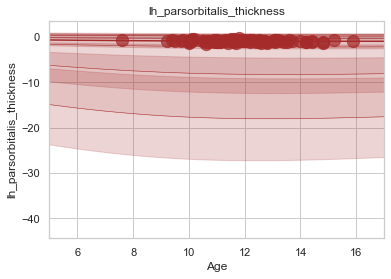

Running IDP 18 lh_parstriangularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15562132]), 'Rho': array([0.70803032]), 'pRho': array([1.17745408e-16]), 'SMSE': array([0.77833997]), 'EXPV': array([0.41121333])}


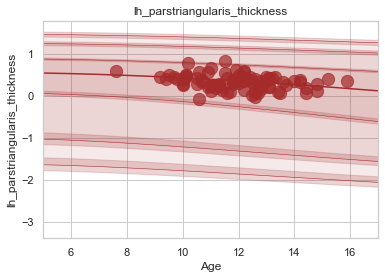

Running IDP 19 lh_pericalcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12795251]), 'Rho': array([0.44794139]), 'pRho': array([6.10543878e-06]), 'SMSE': array([0.89788191]), 'EXPV': array([0.19089874])}


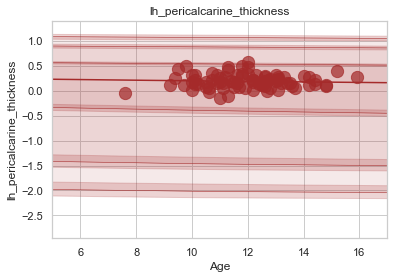

Running IDP 20 lh_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18346043]), 'Rho': array([0.6468249]), 'pRho': array([5.13968736e-13]), 'SMSE': array([1.2172174]), 'EXPV': array([0.33449446])}


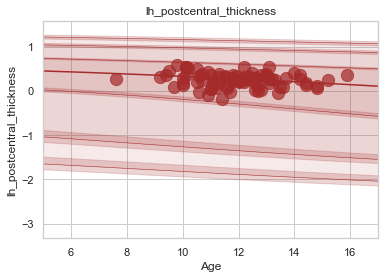

Running IDP 21 lh_posteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12887566]), 'Rho': array([0.6358545]), 'pRho': array([1.83176324e-12]), 'SMSE': array([0.69161174]), 'EXPV': array([0.35382625])}


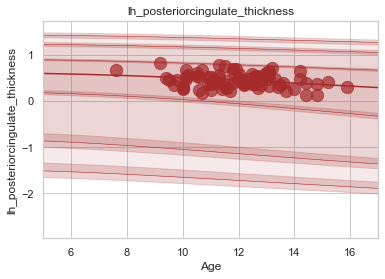

Running IDP 22 lh_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13120088]), 'Rho': array([0.6821624]), 'pRho': array([5.46950788e-15]), 'SMSE': array([0.67332935]), 'EXPV': array([0.38296869])}


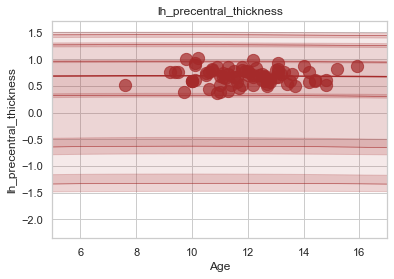

Running IDP 23 lh_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1770128]), 'Rho': array([0.81740099]), 'pRho': array([4.37449249e-27]), 'SMSE': array([1.02343465]), 'EXPV': array([0.48044968])}


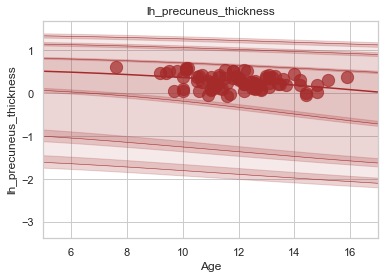

Running IDP 24 lh_rostralanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19781153]), 'Rho': array([0.3708372]), 'pRho': array([0.00025936]), 'SMSE': array([0.86626911]), 'EXPV': array([0.13738194])}


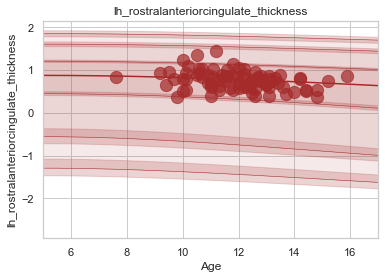

Running IDP 25 lh_rostralmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15885487]), 'Rho': array([0.7217323]), 'pRho': array([1.24920173e-17]), 'SMSE': array([0.86410714]), 'EXPV': array([0.43431724])}


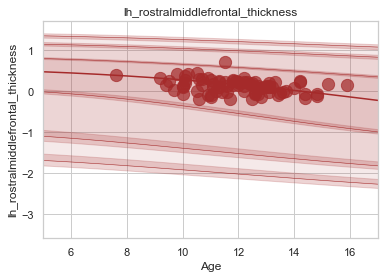

Running IDP 26 lh_superiorfrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16072788]), 'Rho': array([0.74634792]), 'pRho': array([1.4388044e-19]), 'SMSE': array([0.82065821]), 'EXPV': array([0.47097429])}


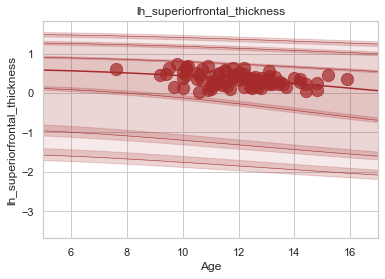

Running IDP 27 lh_superiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.26020427]), 'Rho': array([0.45520731]), 'pRho': array([4.05924738e-06]), 'SMSE': array([2.1815995]), 'EXPV': array([0.20441154])}


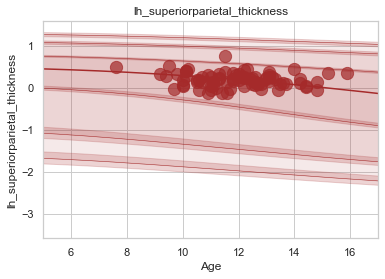

Running IDP 28 lh_superiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11862779]), 'Rho': array([0.83734264]), 'pRho': array([5.79271642e-30]), 'SMSE': array([0.4622383]), 'EXPV': array([0.54260789])}


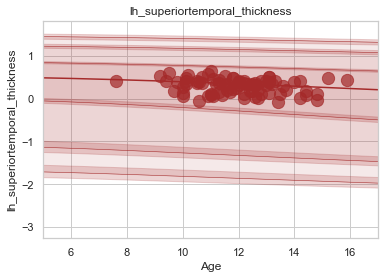

Running IDP 29 lh_supramarginal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14519295]), 'Rho': array([0.80231706]), 'pRho': array([3.5186585e-25]), 'SMSE': array([0.68911287]), 'EXPV': array([0.48538283])}


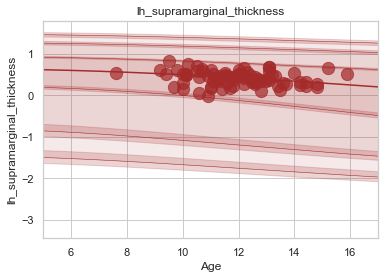

Running IDP 30 lh_frontalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2945628]), 'Rho': array([0.51806069]), 'pRho': array([7.3807883e-08]), 'SMSE': array([0.80565713]), 'EXPV': array([0.21868444])}


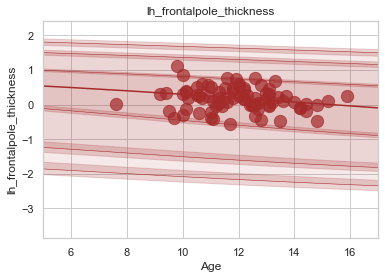

Running IDP 31 lh_temporalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.42239273]), 'Rho': array([0.01885712]), 'pRho': array([0.85957401]), 'SMSE': array([2.07696971]), 'EXPV': array([-0.14292497])}


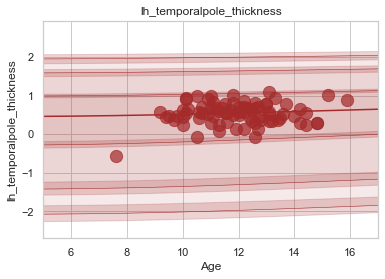

Running IDP 32 lh_transversetemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22765631]), 'Rho': array([0.69826048]), 'pRho': array([5.31462031e-16]), 'SMSE': array([0.76175836]), 'EXPV': array([0.31396562])}


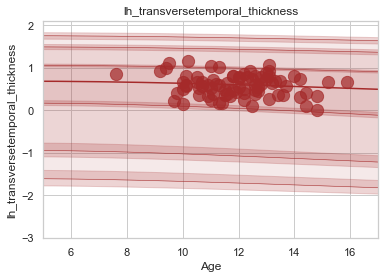

Running IDP 33 lh_insula_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16305934]), 'Rho': array([0.51350286]), 'pRho': array([1.01849881e-07]), 'SMSE': array([0.97174027]), 'EXPV': array([0.24882592])}


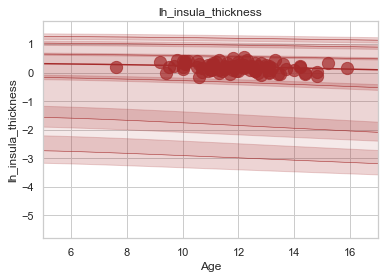

Running IDP 34 rh_bankssts_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18352913]), 'Rho': array([0.70526873]), 'pRho': array([1.81637133e-16]), 'SMSE': array([0.66755483]), 'EXPV': array([0.34404694])}


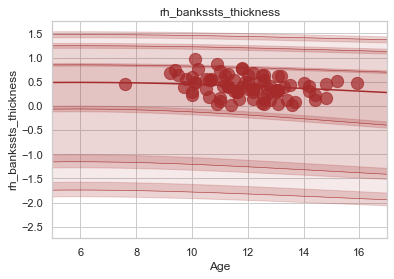

Running IDP 35 rh_caudalanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20951383]), 'Rho': array([0.27534422]), 'pRho': array([0.00801652]), 'SMSE': array([0.926672]), 'EXPV': array([0.07384003])}


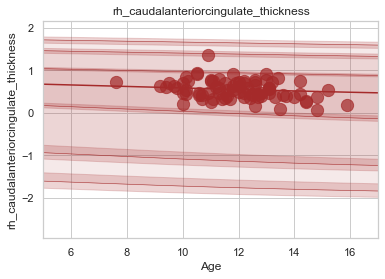

Running IDP 36 rh_caudalmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17808453]), 'Rho': array([0.48528268]), 'pRho': array([6.67346484e-07]), 'SMSE': array([1.04594629]), 'EXPV': array([0.23162182])}


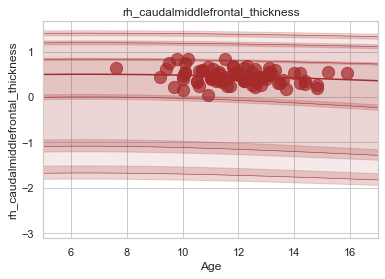

Running IDP 37 rh_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17458239]), 'Rho': array([0.73161365]), 'pRho': array([2.23561279e-18]), 'SMSE': array([0.85681065]), 'EXPV': array([0.34209393])}


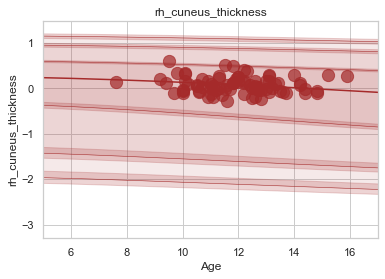

Running IDP 38 rh_entorhinal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.49477415]), 'Rho': array([-0.21204476]), 'pRho': array([0.04340414]), 'SMSE': array([2.09640892]), 'EXPV': array([-0.30774005])}


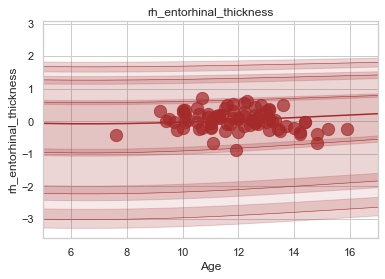

Running IDP 39 rh_fusiform_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15895628]), 'Rho': array([0.37439044]), 'pRho': array([0.0002229]), 'SMSE': array([1.21135702]), 'EXPV': array([0.1007406])}


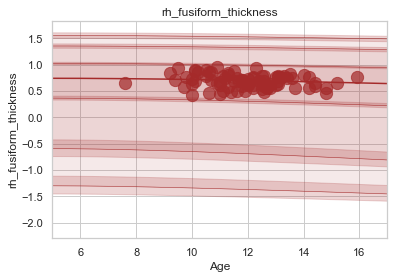

Running IDP 40 rh_inferiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19078993]), 'Rho': array([0.70186357]), 'pRho': array([3.07454622e-16]), 'SMSE': array([1.11113007]), 'EXPV': array([0.39595494])}


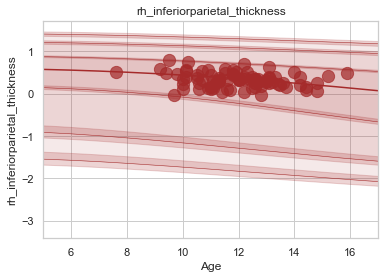

Running IDP 41 rh_inferiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16312931]), 'Rho': array([0.47635244]), 'pRho': array([1.16401288e-06]), 'SMSE': array([1.13286864]), 'EXPV': array([0.21416809])}


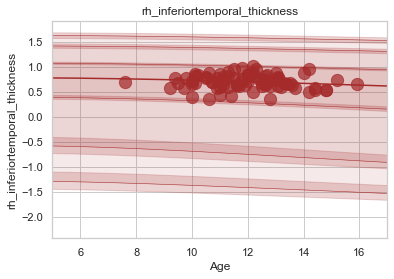

Running IDP 42 rh_isthmuscingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15214306]), 'Rho': array([0.46387072]), 'pRho': array([2.4607636e-06]), 'SMSE': array([0.89854118]), 'EXPV': array([0.21160836])}


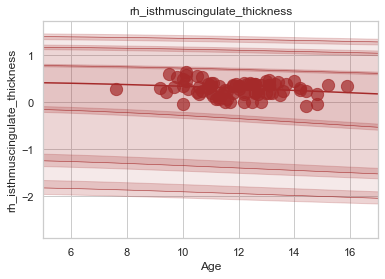

Running IDP 43 rh_lateraloccipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15124508]), 'Rho': array([0.74358348]), 'pRho': array([2.4491852e-19]), 'SMSE': array([0.78587465]), 'EXPV': array([0.39176062])}


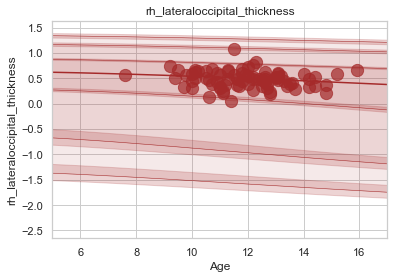

Running IDP 44 rh_lateralorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18116856]), 'Rho': array([0.68839807]), 'pRho': array([2.26487719e-15]), 'SMSE': array([1.07052561]), 'EXPV': array([0.3460365])}


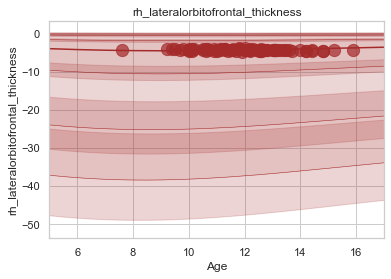

Running IDP 45 rh_lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11049124]), 'Rho': array([0.6318598]), 'pRho': array([2.86719796e-12]), 'SMSE': array([0.70775135]), 'EXPV': array([0.35846991])}


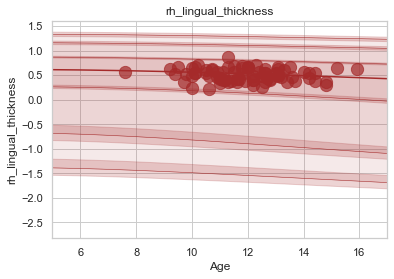

Running IDP 46 rh_medialorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13167668]), 'Rho': array([0.72309822]), 'pRho': array([9.90050889e-18]), 'SMSE': array([0.5642865]), 'EXPV': array([0.45065044])}


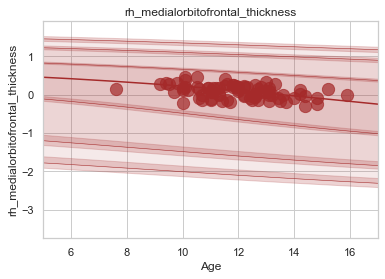

Running IDP 47 rh_middletemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14754412]), 'Rho': array([0.62878127]), 'pRho': array([4.02879987e-12]), 'SMSE': array([0.77458787]), 'EXPV': array([0.37556757])}


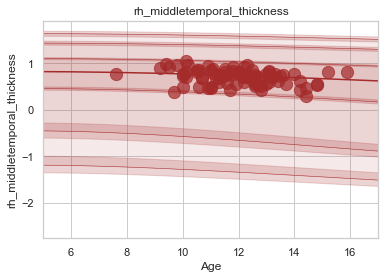

Running IDP 48 rh_parahippocampal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24610684]), 'Rho': array([0.13211929]), 'pRho': array([0.21251607]), 'SMSE': array([1.3711601]), 'EXPV': array([-0.03579118])}


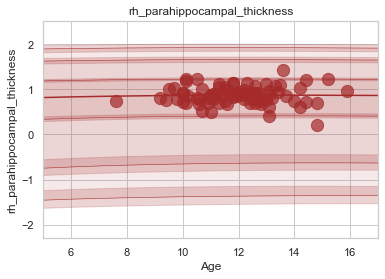

Running IDP 49 rh_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19250223]), 'Rho': array([0.66972701]), 'pRho': array([2.94307211e-14]), 'SMSE': array([0.94481274]), 'EXPV': array([0.34574069])}


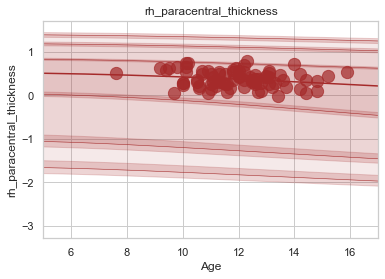

Running IDP 50 rh_parsopercularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14281442]), 'Rho': array([0.73335096]), 'pRho': array([1.63637222e-18]), 'SMSE': array([0.64041569]), 'EXPV': array([0.41957678])}


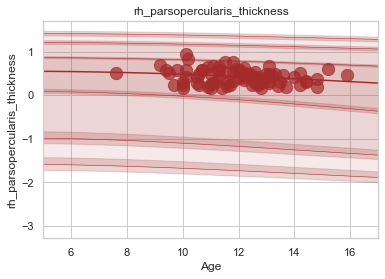

Running IDP 51 rh_parsorbitalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16974601]), 'Rho': array([0.71088844]), 'pRho': array([7.46999173e-17]), 'SMSE': array([0.49930449]), 'EXPV': array([0.50338736])}


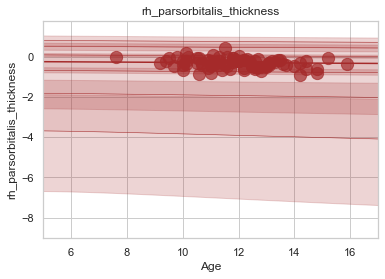

Running IDP 52 rh_parstriangularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17367619]), 'Rho': array([0.74596814]), 'pRho': array([1.54865024e-19]), 'SMSE': array([0.7459573]), 'EXPV': array([0.40052453])}


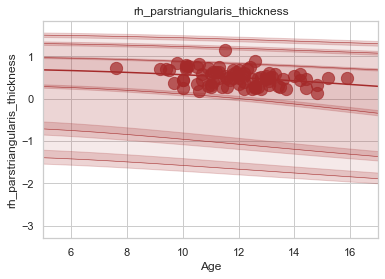

Running IDP 53 rh_pericalcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14433977]), 'Rho': array([0.44592453]), 'pRho': array([6.82538463e-06]), 'SMSE': array([0.9212621]), 'EXPV': array([0.16897493])}


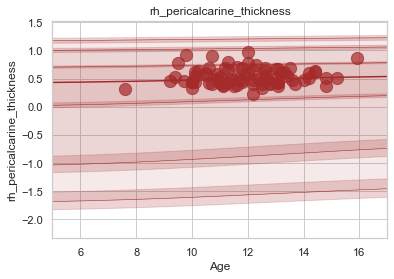

Running IDP 54 rh_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18812185]), 'Rho': array([0.64560134]), 'pRho': array([5.94027889e-13]), 'SMSE': array([1.37009108]), 'EXPV': array([0.33848197])}


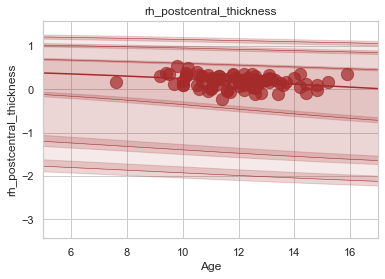

Running IDP 55 rh_posteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1213147]), 'Rho': array([0.63156019]), 'pRho': array([2.96427932e-12]), 'SMSE': array([0.68236679]), 'EXPV': array([0.35645534])}


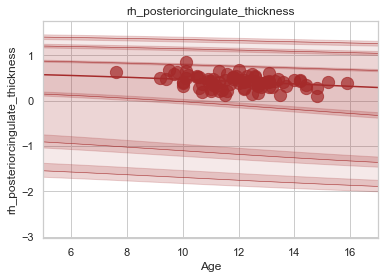

Running IDP 56 rh_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12820997]), 'Rho': array([0.70113999]), 'pRho': array([3.43443388e-16]), 'SMSE': array([0.68458058]), 'EXPV': array([0.39080493])}


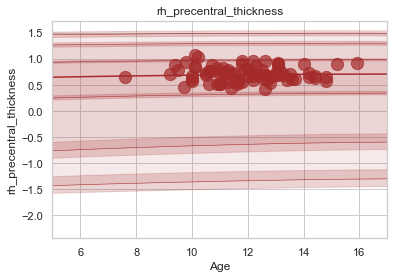

Running IDP 57 rh_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18197267]), 'Rho': array([0.74396563]), 'pRho': array([2.27666708e-19]), 'SMSE': array([1.20079779]), 'EXPV': array([0.42993509])}


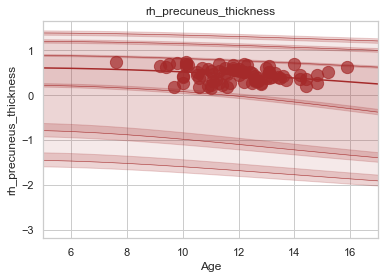

Running IDP 58 rh_rostralanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21957983]), 'Rho': array([0.20517533]), 'pRho': array([0.05088756]), 'SMSE': array([1.20929925]), 'EXPV': array([-0.17950974])}


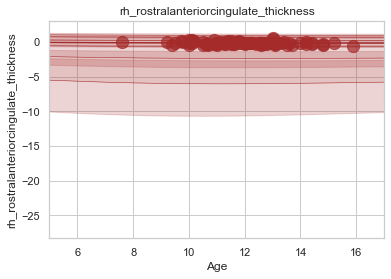

Running IDP 59 rh_rostralmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17753022]), 'Rho': array([0.73175987]), 'pRho': array([2.1779086e-18]), 'SMSE': array([0.90399844]), 'EXPV': array([0.41944246])}


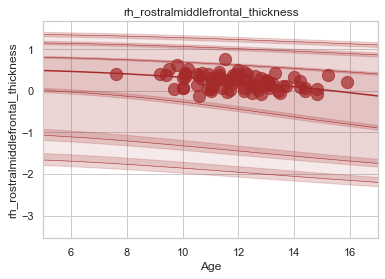

Running IDP 60 rh_superiorfrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16438415]), 'Rho': array([0.70817751]), 'pRho': array([1.15036694e-16]), 'SMSE': array([0.92535772]), 'EXPV': array([0.44649371])}


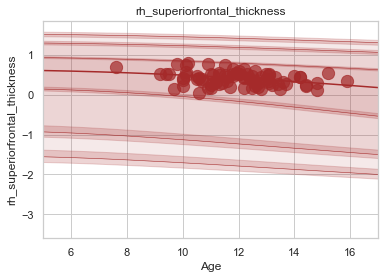

Running IDP 61 rh_superiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.26390871]), 'Rho': array([0.48340379]), 'pRho': array([7.51320017e-07]), 'SMSE': array([1.93791625]), 'EXPV': array([0.22047517])}


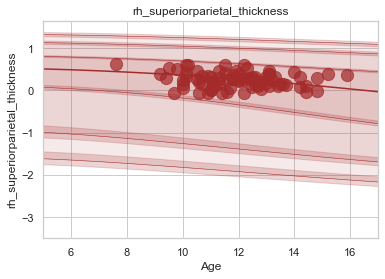

Running IDP 62 rh_superiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.150299]), 'Rho': array([0.826692]), 'pRho': array([2.27098093e-28]), 'SMSE': array([0.53668909]), 'EXPV': array([0.46400083])}


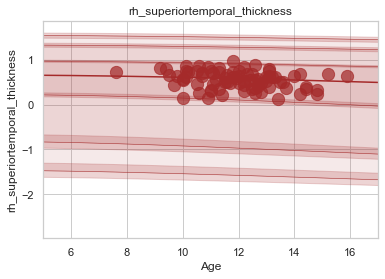

Running IDP 63 rh_supramarginal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15128568]), 'Rho': array([0.79596551]), 'pRho': array([1.94838942e-24]), 'SMSE': array([0.753795]), 'EXPV': array([0.48903468])}


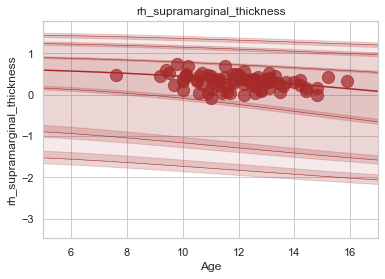

Running IDP 64 rh_frontalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28675131]), 'Rho': array([0.66288603]), 'pRho': array([7.13391617e-14]), 'SMSE': array([0.74691894]), 'EXPV': array([0.33426397])}


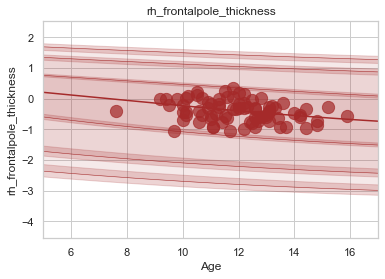

Running IDP 65 rh_temporalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.53976916]), 'Rho': array([-0.05805498]), 'pRho': array([0.5856042]), 'SMSE': array([2.18889462]), 'EXPV': array([-0.18945709])}


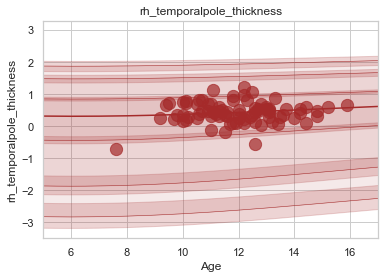

Running IDP 66 rh_transversetemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24050383]), 'Rho': array([0.69776354]), 'pRho': array([5.72696147e-16]), 'SMSE': array([0.7964265]), 'EXPV': array([0.30714237])}


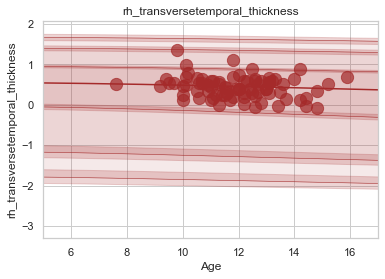

Running IDP 67 rh_insula_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15587077]), 'Rho': array([0.60357623]), 'pRho': array([5.56819477e-11]), 'SMSE': array([0.91679398]), 'EXPV': array([0.36388327])}


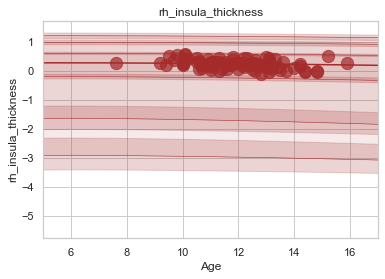

In [63]:
if (sex == 2): 
    clr = 'brown';
else:
    clr = 'blue'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), len(cols_cov)))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, 
                               site_ids=None, 
                               all_sites=site_ids_tr
                              )

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set

            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue

            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 

            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]

            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue

            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        
        plt.scatter(X_te[idx,1], y_te_rescaled, s=150, color=clr, alpha = 0.7)
        
    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.2,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
#     plt.ylim(-1, 4)
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((5,17))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)